## Data Wranglin'
#### Downloading, viewing, cleaning, processing data for modeling use

### Imports and settings

In [1]:
import pandas as pd
import os
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.core.display import display
pd.set_option('display.max_columns', None)

2023-07-26 11:43:18.842194: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 11:43:19.250700: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-26 11:43:20.173077: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2023-07-26 11:43:20.173285: W tensorflow/compiler/xla/stream_exe

### Urls and local storage locations

In [7]:
COINBASE_loc = "data/coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv"
BITSTAMP_loc = "data/bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv"

COINBASE_url = 'https://drive.google.com/file/d/16MgiuBfQKzXPoWFWi2w-LKJuZ7LgivpE/view?usp=sharing'
BITSTAMP_url = 'https://drive.google.com/file/d/15A-rLSrfZ0td7muSrYHy0WX9ZqrMweES/view?usp=sharing'

### Preprocessing method for use prior to training

In [31]:
"""Time Series Forecasting of Bitcoin Prices using Keras"""


def preprocess_data(data_loc: str) -> pd.DataFrame:
    """converts raw data for use in time series forecasting"""
    
    #read in data
    df = pd.read_csv(data_loc)
    
    #grab only timestamp and weighted price
    df = df[['Timestamp', 'Weighted_Price']]
    
    #convert timestamp to datetime
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
    df['Weighted_Price_filled'] = df['Weighted_Price'].rolling(window=24,
                                                               min_periods=1).mean()
    df['Weighted_Price'].fillna(df['Weighted_Price_filled'], inplace=True)
    df.drop(['Weighted_Price_filled'], axis=1, inplace=True)
    
    #drop any remaining null values
    df.dropna(inplace=True)
    
    # remove data from before 2017
    mask = df['Timestamp'] >= pd.to_datetime(f'2017-01-01')
    df = df[mask]
    
    #split the data into train, val, and test sets
    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]
    
    #normalize the data based off of the training set only (to prevent data leakage)
    train_mean = train_df['Weighted_Price'].mean()
    train_std = train_df['Weighted_Price'].std()
    train_df['Weighted_Price'] = (train_df['Weighted_Price'] - train_df['Weighted_Price'].mean()) / train_df['Weighted_Price'].std()
    val_df['Weighted_Price'] = (val_df['Weighted_Price'] - train_mean) / train_std
    test_df['Weighted_Price'] = (test_df['Weighted_Price'] - train_mean) / train_std
    
    #time change to 1 hour
    train_df = train_df[0::60]
    val_df = val_df[0::60]
    test_df = test_df[0::60]
    
    
    return train_df, val_df, test_df


### df Objects

In [32]:
bit_train_df, bit_val_df, bit_test_df  = preprocess_data(BITSTAMP_loc)

/tmp/ipykernel_17502/330784552.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Weighted_Price'] = (train_df['Weighted_Price'] - train_df['Weighted_Price'].mean()) / train_df['Weighted_Price'].std()
/tmp/ipykernel_17502/330784552.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['Weighted_Price'] = (val_df['Weighted_Price'] - train_mean) / train_std
/tmp/ipykernel_17502/330784552.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

### Checking for NaNs
#### (Not needed now)

In [5]:

total_rows_with_nan = coinDf.isnull().any(axis=1).sum()
print(coinDf.head())
print(total_rows_with_nan)
print(bitDf.shape)
print(coinDf.shape)


               Timestamp  Weighted_Price
0    2014-12-01 05:33:00      300.000000
82   2014-12-01 06:55:00      370.000000
1783 2014-12-02 11:16:00      377.994792
2317 2014-12-02 20:10:00      378.000000
2926 2014-12-03 06:19:00      378.000000
0
(67260, 2)
(34629, 2)


### Comparison Plots

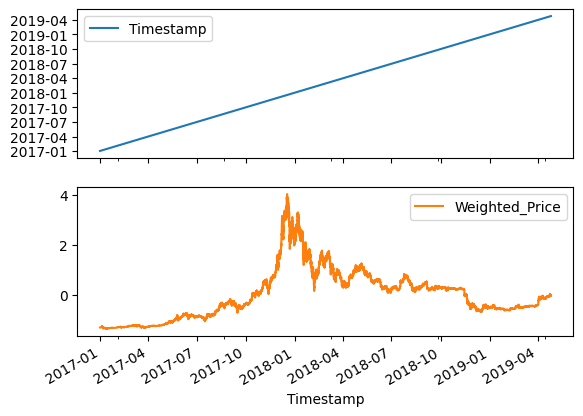

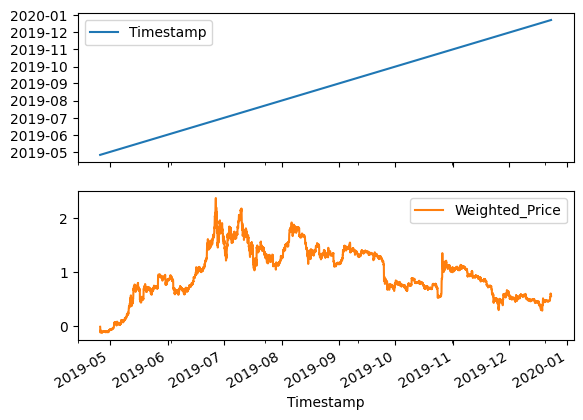

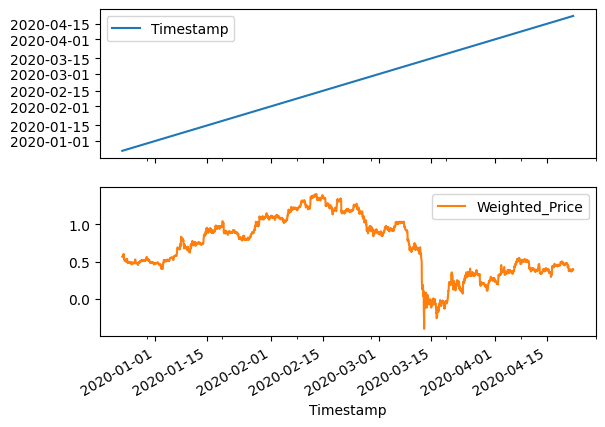

In [33]:
plot_cols = ['Timestamp', 'Weighted_Price']

# Training set plot
plot_features = bit_train_df[plot_cols]
plot_features.index = bit_train_df['Timestamp']
_ = plot_features.plot(subplots=True)

# Validation set plot
plot_features = bit_val_df[plot_cols]
plot_features.index = bit_val_df['Timestamp']
_ = plot_features.plot(subplots=True)

# Test set plot
plot_features = bit_test_df[plot_cols]
plot_features.index = bit_test_df['Timestamp']
_ = plot_features.plot(subplots=True)
# plot_features = coinDf[plot_cols]
# plot_features.index = coinDf['Timestamp']
# _ = plot_features.plot(subplots=True)

## Model Building
#### RNN Architecture based on TF/Keras documentation example